In [1]:
import pandas as pd
import seaborn as sns
import os.path as osp
import networkx as nx

import hetnetpy.hetnet
import hetnetpy.readwrite
import hetnetpy.stats

from hetnetpy.abbreviation import metaedges_from_metapath
import re
import json
from collections import Counter

import random
import numpy as np
seed = 123
random.seed(seed)
np.random.seed(seed)

from tqdm import tqdm

%matplotlib inline

Load in the KG, which we took from the PoLo dir:

In [2]:
KG_DIR = '../data/kg/splits'
HETIONET_DIR = osp.join(KG_DIR, 'Hetionet')
MARS_DIR = osp.join(HETIONET_DIR, 'MARS')

kg_w_train = pd.read_csv(osp.join(MARS_DIR, 'graph_triples.txt', ), sep='\t', header=None)
train = pd.read_csv(osp.join(MARS_DIR, 'train.txt', ), sep='\t', header=None)
test = pd.read_csv(osp.join(MARS_DIR, 'test.txt', ), sep='\t', header=None)
val = pd.read_csv(osp.join(MARS_DIR, 'dev.txt', ), sep='\t', header=None)

In [3]:
kg = kg_w_train.loc[kg_w_train[1] != 'CtD']

In [4]:
len(kg) + len(train) == len(kg_w_train)

True

Define and Instantiate Metagraph:

In [5]:
kind_to_abbev = {
    
    # metanodes
    'Compound': 'C',
    'Disease': 'D',
    'Gene': 'G',
    'Anatomy': 'A',
    'Symptom': 'S',
    'Side_Effect': 'SE',
    'Pathway': 'PW',
    'Pharmacologic_Class': 'PC',
    'Biological_Process': 'BP',
    'Cellular_Component': 'CC',
    'Molecular_Function': 'MF',
    
    # metaedges
    'treats': 't',
    'palliates': 'p',
    'binds': 'b',
    'expresses': 'e',
    'regulates': 'r>',
    'upregulates': 'u',
    'downregulates': 'd',
    'interacts': 'i',
    'includes': 'i',
    'covaries': 'c',
    'participates': 'p',
    'resembles': 'r',
    'associates': 'a',
    'localizes': 'l',
    'presents': 'p',
    'causes': 'c',
}

metaedge_tuples = [
    ('Compound', 'Disease', 'treats', 'forward'),
    ('Compound', 'Disease', 'palliates', 'forward'),
    ('Compound', 'Gene', 'binds', 'forward'),
    ('Compound', 'Gene', 'upregulates', 'forward'),
    ('Compound', 'Gene', 'downregulates', 'forward'),
    ('Compound', 'Compound', 'resembles', 'forward'),
    ('Compound', 'Side_Effect', 'causes', 'forward'),
    ('Pharmacologic_Class', 'Compound', 'includes', 'forward'),
    ('Anatomy', 'Gene', 'expresses', 'forward'),
    ('Anatomy', 'Gene', 'upregulates', 'forward'),
    ('Anatomy', 'Gene', 'downregulates', 'forward'),
    ('Gene', 'Gene', 'interacts', 'forward'),
    ('Gene', 'Gene', 'covaries', 'forward'),
    ('Gene', 'Gene', 'regulates', 'forward'),
    ('Gene', 'Pathway', 'participates', 'forward'),
    ('Gene', 'Biological_Process', 'participates', 'forward'),
    ('Gene', 'Cellular_Component', 'participates', 'forward'),
    ('Gene', 'Molecular_Function', 'participates', 'forward'),
    ('Disease', 'Disease', 'resembles', 'forward'),
    ('Disease', 'Gene', 'associates', 'forward'),
    ('Disease', 'Gene', 'upregulates', 'forward'),
    ('Disease', 'Gene', 'downregulates', 'forward'),
    ('Disease', 'Anatomy', 'localizes', 'forward'),
    ('Disease', 'Symptom', 'presents', 'forward'),
]
metagraph = hetnetpy.hetnet.MetaGraph.from_edge_tuples(metaedge_tuples, kind_to_abbev)
graph = hetnetpy.hetnet.Graph(metagraph)

In [6]:
rev_kind_to_abbev = {v: k for k, v in kind_to_abbev.items()}

In [7]:
metaedge_tuple_dict = {(i[0], i[1], i[2][0]): i[2] for i in metaedge_tuples}

In [8]:
def get_relation_name(source, target, middle_letter):
    return metaedge_tuple_dict[(source, target, middle_letter[0])]

In [9]:
def get_metaedge(meta_relation):
    lowers = re.findall(r'[a-z]+', meta_relation)
    uppers = re.findall(r'[A-Z]+', meta_relation)
    source = rev_kind_to_abbev[uppers[0]]
    target = rev_kind_to_abbev[uppers[1]]
    rel = get_relation_name(source, target, lowers)
    directn = 'forward' if rel == 'regulates' else 'both'
    return source, target, rel, directn

In [10]:
seen = set()

for i, row in tqdm(kg.iterrows()):
    src_id = row[0].split('::')[1]
    src_type = row[0].split('::')[0]
    trgt_id = row[2].split('::')[1]
    trgt_type = row[2].split('::')[0]

    if not src_id in seen:
        graph.add_node(kind=src_type, identifier=src_id)
        seen.add(src_id)
        
    if not trgt_id in seen:
        graph.add_node(kind=trgt_type, identifier=trgt_id)
        seen.add(trgt_id)

    source, target, rel, directn = get_metaedge(row[1])
    src_input = src_type, src_id
    trgt_input = trgt_type, trgt_id

    graph.add_edge(source_id=src_input, target_id=trgt_input, kind=rel, direction='forward')

2249442it [04:06, 9124.83it/s] 


## Network Visualization and Stats

In [11]:
metanode_df = hetnetpy.stats.get_metanode_df(graph)
metanode_df

,metanode,abbreviation,metaedges,nodes,unconnected_nodes
1,Anatomy,A,4,400,0
2,Biological_Process,BP,1,11381,0
8,Cellular_Component,CC,1,1391,0
4,Compound,C,8,1538,0
3,Disease,D,8,136,0
0,Gene,G,16,19145,0
6,Molecular_Function,MF,1,2884,0
7,Pathway,PW,1,1822,0
10,Pharmacologic_Class,PC,1,345,0
5,Side_Effect,SE,1,5701,0


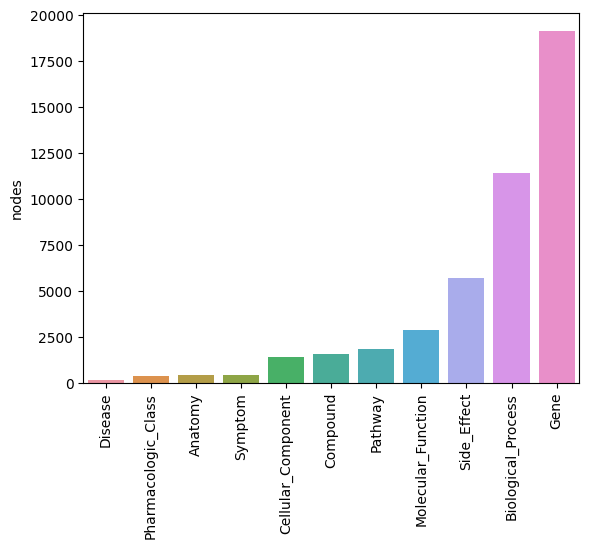

In [12]:
ax = sns.barplot(x='metanode', y='nodes', data=metanode_df.sort_values('nodes'))
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
ax.set_xlabel(''); ax.set_ylabel('nodes');

In [13]:
# Total number of nodes
metanode_df.nodes.sum()

45158

In [14]:
# Summary of metaedges and cooresponding edges
metaedge_df = hetnetpy.stats.get_metaedge_df(graph)

metaedge_df

,metaedge,abbreviation,edges,source_nodes,target_nodes
10,Anatomy > downregulates > Gene,Ad>G,102240,36,15097
8,Anatomy > expresses > Gene,Ae>G,526407,241,18094
9,Anatomy > upregulates > Gene,Au>G,97848,36,15929
2,Compound > binds > Gene,Cb>G,11571,1389,1689
6,Compound > causes > Side_Effect,Cc>SE,138944,1071,5701
4,Compound > downregulates > Gene,Cd>G,21102,734,2880
1,Compound > palliates > Disease,Cp>D,390,221,50
5,Compound > resembles > Compound,Cr>C,6486,1042,1054
0,Compound > treats > Disease,Ct>D,0,0,0
3,Compound > upregulates > Gene,Cu>G,18756,703,3247


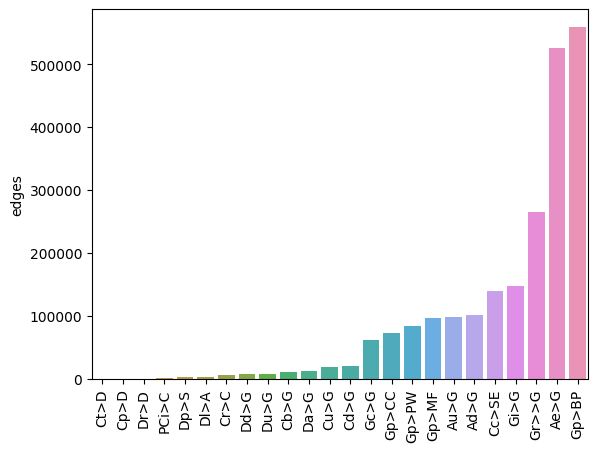

In [15]:
ax = sns.barplot(x='abbreviation', y='edges', data=metaedge_df.sort_values('edges'))
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
ax.set_xlabel(''); ax.set_ylabel('edges');

In [16]:
# Summary of different styles for representing each metaedge
metaedge_style_df = hetnetpy.stats.get_metaedge_style_df(metagraph)
metaedge_style_df.head()

,metaedge,unicode_metaedge,standard_metaedge,abbreviation,standard_abbreviation,source,target,inverted
45,Anatomy < localizes < Disease,Anatomy←localizes←Disease,Disease > localizes > Anatomy,A<lD,DlA,Anatomy,Disease,1
20,Anatomy > downregulates > Gene,Anatomy→downregulates→Gene,Anatomy > downregulates > Gene,Ad>G,AdG,Anatomy,Gene,0
16,Anatomy > expresses > Gene,Anatomy→expresses→Gene,Anatomy > expresses > Gene,Ae>G,AeG,Anatomy,Gene,0
18,Anatomy > upregulates > Gene,Anatomy→upregulates→Gene,Anatomy > upregulates > Gene,Au>G,AuG,Anatomy,Gene,0
31,Biological_Process < participates < Gene,Biological_Process←participates←Gene,Gene > participates > Biological_Process,BP<pG,GpBP,Biological_Process,Gene,1


In [17]:
# Number of edges in the network
metaedge_df.edges.sum()

2249442

## Metapath Extraction

Here, we have functions which can extract metapaths:

In [18]:
tgt_metapaths = metagraph.extract_metapaths(source='Compound', target='Disease')
print(tgt_metapaths)

[Cp>D, Ct>D, C<rCp>D, C<rCt>D, Cr>Cp>D, Cr>Ct>D, Cp>D<rD, Cp>Dr>D, Ct>D<rD, Ct>Dr>D, Cb>G<aD, Cb>G<dD, Cb>G<uD, Cd>G<aD, Cd>G<dD, Cd>G<uD, Cu>G<aD, Cu>G<dD, Cu>G<uD, C<rC<rCp>D, C<rC<rCt>D, C<rCr>Cp>D, C<rCr>Ct>D, C<rCp>D<rD, C<rCp>Dr>D, C<rCt>D<rD, C<rCt>Dr>D, C<rCb>G<aD, C<rCb>G<dD, C<rCb>G<uD, C<rCd>G<aD, C<rCd>G<dD, C<rCd>G<uD, C<rCu>G<aD, C<rCu>G<dD, C<rCu>G<uD, Cr>C<rCp>D, Cr>C<rCt>D, Cr>Cr>Cp>D, Cr>Cr>Ct>D, Cr>Cp>D<rD, Cr>Cp>Dr>D, Cr>Ct>D<rD, Cr>Ct>Dr>D, Cr>Cb>G<aD, Cr>Cb>G<dD, Cr>Cb>G<uD, Cr>Cd>G<aD, Cr>Cd>G<dD, Cr>Cd>G<uD, Cr>Cu>G<aD, Cr>Cu>G<dD, Cr>Cu>G<uD, Cp>Dl>A<lD, Cp>D<pCp>D, Cp>D<pCt>D, Cp>D<tCp>D, Cp>D<tCt>D, Cp>D<rD<rD, Cp>D<rDr>D, Cp>Dr>D<rD, Cp>Dr>Dr>D, Cp>Da>G<aD, Cp>Da>G<dD, Cp>Da>G<uD, Cp>Dd>G<aD, Cp>Dd>G<dD, Cp>Dd>G<uD, Cp>Du>G<aD, Cp>Du>G<dD, Cp>Du>G<uD, Cp>Dp>S<pD, Ct>Dl>A<lD, Ct>D<pCp>D, Ct>D<pCt>D, Ct>D<tCp>D, Ct>D<tCt>D, Ct>D<rD<rD, Ct>D<rDr>D, Ct>Dr>D<rD, Ct>Dr>Dr>D, Ct>Da>G<aD, Ct>Da>G<dD, Ct>Da>G<uD, Ct>Dd>G<aD, Ct>Dd>G<dD, Ct>Dd>G<uD, Ct>Du>G<aD, Ct>Du>

In [19]:
CtoD_metapaths = []

for i in tgt_metapaths:
    if '<' in repr(i):  # get rid of those with inverse edges
        continue
    if repr(i) != 'Ct>D':
        CtoD_metapaths.append(i)

How many did it prune?

In [20]:
print(len(CtoD_metapaths))
print(len(tgt_metapaths))

19
1999


## Format rules in the MARS style:

In [21]:
prob = 0.5

In [22]:
def get_forward_rule_body(mpath, conf, metagraph):
    """Gets the rule body for a given metapath in the format that MARS requires
        :param mpath: the metapath instance, written in hetnetpy format
        :param conf: the confidence value to use for the rule
        :param metagraph: the metagraph instance, as a hetnetpy object
    """
    st_edges = metaedges_from_metapath(mpath, standardize_by=metagraph)
    directional_edges = metaedges_from_metapath(mpath)
    rule_head = re.split('>|<|[^A-Z]', mpath)
    rule_head = rule_head[0] + 't' + rule_head[-1]
    rule_body = [conf, rule_head]
    for st, dic in zip(st_edges, directional_edges):
        if '>' in dic:
            rule_body.append(st)
        else:
            rule_body.append('_' + st)
    return rule_body

In [23]:
rules = {}
rules['CtD'] = [get_forward_rule_body(str(mpath), prob, metagraph) for mpath in CtoD_metapaths]
print(rules)

{'CtD': [[0.5, 'CtD', 'CpD'], [0.5, 'CtD', 'CrC', 'CpD'], [0.5, 'CtD', 'CrC', 'CtD'], [0.5, 'CtD', 'CpD', 'DrD'], [0.5, 'CtD', 'CtD', 'DrD'], [0.5, 'CtD', 'CrC', 'CrC', 'CpD'], [0.5, 'CtD', 'CrC', 'CrC', 'CtD'], [0.5, 'CtD', 'CrC', 'CpD', 'DrD'], [0.5, 'CtD', 'CrC', 'CtD', 'DrD'], [0.5, 'CtD', 'CpD', 'DrD', 'DrD'], [0.5, 'CtD', 'CtD', 'DrD', 'DrD'], [0.5, 'CtD', 'CrC', 'CrC', 'CrC', 'CpD'], [0.5, 'CtD', 'CrC', 'CrC', 'CrC', 'CtD'], [0.5, 'CtD', 'CrC', 'CrC', 'CpD', 'DrD'], [0.5, 'CtD', 'CrC', 'CrC', 'CtD', 'DrD'], [0.5, 'CtD', 'CrC', 'CpD', 'DrD', 'DrD'], [0.5, 'CtD', 'CrC', 'CtD', 'DrD', 'DrD'], [0.5, 'CtD', 'CpD', 'DrD', 'DrD', 'DrD'], [0.5, 'CtD', 'CtD', 'DrD', 'DrD', 'DrD']]}


In [24]:
# write the rules to file
with open(osp.join(MARS_DIR, 'rules.txt'), 'w') as f:
    json.dump(rules, f)